In [1]:
import numpy as np
import pandas as pd
import random
import sys
from trmf import trmf
import matplotlib.pyplot as plt
%matplotlib inline
from trmf_regressor import *

sys.path.insert(1,'D:\TMU_codes\Thesis_codes\codes')

from package.loadDb import *
from package.featureSelection_TENSORIZED import *

In [2]:
# # import kaggle dataset
# address = "..\database\kaggleDataFrame"

# data_with_target= load_kaggle_dataframe(address+"\dataframes.csv")

# data_with_target=data_with_target.iloc[:20000]

# data_without_target = data_with_target.drop(['DEMAND'],axis=1)

# target=data_with_target.iloc[:,-1]
# print("data with target size = ",data_with_target.shape )


# data with target column
address = "..\database\stock market dataset"
data_with_target=load_stock_market_dataframe(address+"\sample_normalized_with_target.csv")
data_with_target=data_with_target.iloc[:20000]
data_without_target = data_with_target.drop(['TARGET'],axis=1)
# data_without_target=data_with_target.iloc[:,:-1]
target=data_with_target.iloc[:,-1]

In [3]:
data_with_target.head()

yy        mm       ret       prc      size       q10  \
date       permno                                                               
1962-07-31 19940  -2.648223  0.145450 -0.146413  0.019617 -0.120717 -1.063216   
           25160  -2.648223  0.145450 -0.316945  0.009621 -0.159645 -1.063216   
1962-08-31 19940  -2.648223  0.434492  0.549665  0.025122 -0.120717 -1.051197   
           25160  -2.648223  0.434492  0.083099  0.010490 -0.159645 -1.051197   
1962-09-30 19940  -2.648223  0.723534 -0.381573  0.021790 -0.120717 -1.050753   

                        q20       q30       q40       q50  ...  beta_daily  \
date       permno                                          ...               
1962-07-31 19940  -1.079224 -1.129578 -1.156967 -1.210099  ...    0.012111   
           25160  -1.079224 -1.129578 -1.156967 -1.210099  ...    0.237826   
1962-08-31 19940  -1.071258 -1.119878 -1.150597 -1.202454  ...   -0.298068   
           25160  -1.071258 -1.119878 -1.150597 -1.202454  ...   -0.190870   
1962-09-30 19940  -1.070844 -1.117299 -1.147227 -1.199107  ...    0.153155   

                   idio_vol  total_vol  std_volume  std_turn   lme_adj  \
date       permno                                                        
1962-07-31 19940  -0.170310  -0.117195   -0.127241 -0.306714 -0.004726   
           25160  -0.493377  -0.238926   -0.127233 -0.267125 -0.052931   
1962-08-31 19940  -0.679408  -0.751803   -0.127207 -0.306133 -0.005374   
           25160  -0.503803  -0.560414   -0.127233 -0.267104 -0.054238   
1962-09-30 19940  -0.639003  -0.648479   -0.127103 -0.304431 -0.002141   

                   beme_adj    pm_adj    at_adj    TARGET  
date       permno                                          
1962-07-31 19940  -0.605992 -0.004893  0.914182  0.549665  
           25160   0.697669 -0.005120 -0.767922  0.083099  
1962-08-31 19940  -0.605992 -0.004893  0.914182 -0.381573  
           25160   0.697669 -0.005120 -0.767922 -0.442115  
1962-09-30 19940  -0.605992 -0.004893  0.914182 -0.240096  

[5 rows x 77 columns]

In [4]:
target

date        permno
1962-07-31  19940     0.549665
            25160     0.083099
1962-08-31  19940    -0.381573
            25160    -0.442115
1962-09-30  19940    -0.240096
                        ...   
1968-04-30  10006    -0.184283
            10102     0.046818
            10145    -0.064218
            10153     0.212999
            10161     0.059429
Name: TARGET, Length: 20000, dtype: float64

In [6]:
# plt.figure(figsize=(15,8))
# plt.plot(data_without_target.iloc[:,-1], color='blue')

# plt.xlabel('timepoint')
# plt.ylabel('value')

# plt.show()

In [7]:
def normalized_data(data, T_train, T_start, normalize=True):
    N = len(data)
    # split on train and test
    train = data[:, T_start:T_start+T_train].copy()

    # normalize data
    if normalize:
        mean_train = np.array([])
        std_train = np.array([])
        for i in range(len(train)):
            if (~np.isnan(train[i])).sum() == 0:
                mean_train = np.append(mean_train, 0)
                std_train = np.append(std_train, 0)
            else:
                mean_train = np.append(mean_train, train[i][~np.isnan(train[i])].mean())
                std_train = np.append(std_train, train[i][~np.isnan(train[i])].std())
        
        std_train[std_train == 0] = 1.

        train -= mean_train.repeat(T_train).reshape(N, T_train)
        train /= std_train.repeat(T_train).reshape(N, T_train)
    return train

In [8]:
def xgboost_reg_error(data_without_target,target,testSize):
    """
    while splitting data shuffle is false due to keep time series sampales in order
    """
    x_train, x_test, y_train, y_test = train_test_split(data_without_target, target, test_size = testSize,shuffle=False)

    model =  xg.XGBRegressor()
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    # rmse=np.sqrt(metrics.mean_squared_error(y_test, predictions))
    rmse=np.linalg.norm(predictions-y_test)/np.linalg.norm(y_test)
    # print("MSE  is:{:.2f}".format(pca_mse))
    return rmse

In [9]:
testSize=500
lags = [1,25]
K = 4
lambda_f = 1.
lambda_x = 1
lambda_w = 1.
alpha = 1000.
eta = 1.
max_iteration=10000
num_comp=K

In [10]:
interval=2000
counter=0
pca_list=[]
dict_mse={}

while counter+interval <= data_without_target.shape[0]:


    datacut=data_with_target[counter:counter+interval]
    X_datacut=datacut.iloc[:,:-1]
    Y_datacut=datacut.iloc[:,-1]
    # print(counter,X_datacut.shape)
    X_pca=compute_pca(X_datacut,num_comp=num_comp)

    pca_mse=xgboost_reg_error(X_pca,Y_datacut,testSize)
    pca_list.append(pca_mse)##########################
    counter+=interval
dict_mse['PCA']=pca_list

In [11]:
trmf_rmse_list=[]
counter=0
while counter+interval <= data_without_target.shape[0]:
    
    data=data_without_target.to_numpy().T
    data=data[:,counter:counter+interval]
    # display(data)
    target_cut=target.iloc[counter:counter+interval]
    T_train = data.shape[1]
    train =normalized_data(data, T_train, 0, normalize=True)
    # display(train)
    # display(test)

    model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta)
    model.fit(train, max_iter = max_iteration)
    # train_preds = np.dot(model.F, model.X)
    # test_preds = model.predict(T_test)[-1]
    new_features=model.X.T
    rmse=xgboost_reg_error(new_features,target_cut,testSize)
    trmf_rmse_list.append(rmse)
    counter+=interval
    print(counter/interval)
    print("----------------------------------------------------------------------------")
dict_mse['trmf_rmse']=trmf_rmse_list


1.0
----------------------------------------------------------------------------
2.0
----------------------------------------------------------------------------
3.0
----------------------------------------------------------------------------
4.0
----------------------------------------------------------------------------
5.0
----------------------------------------------------------------------------
6.0
----------------------------------------------------------------------------
7.0
----------------------------------------------------------------------------
8.0
----------------------------------------------------------------------------
9.0
----------------------------------------------------------------------------
10.0
----------------------------------------------------------------------------


In [12]:
sys.path.insert(1, 'D:/TMU/thesis/codes')

from package.featureSelection_TEMPORAL_PAGERANK import *

In [13]:
dict_mse_tpr={}

for window_size in [2,3,4,5,6,7,10,30]:
    method_list = []
    counter=0

    while counter+interval <= data_without_target.shape[0]:


        datacut=data_with_target[counter:counter+interval]
        X_datacut=datacut.iloc[:,:-1]
        Y_datacut=datacut.iloc[:,-1]

        arr=create_graph_details(X_datacut,window_size)
        a=featureSelection_tpr(arr,X_datacut.shape[1],num_comp)
        mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)

        method_list.append(mse_tpr)
        #     print( "method_list",method_list)
        print(counter/interval)
        print("----------------------------------------------------------------------------")
        counter+=interval
    dict_mse_tpr["T-PR win={}".format(window_size)]=method_list
dataframe_1 = pd.DataFrame(dict_mse_tpr)
dict_mse['temp_PR_rmse']=list(dataframe_1.min(axis=1))

C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


0.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


2.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


6.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


8.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


9.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


0.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


2.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


6.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


8.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


9.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


0.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


2.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


6.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


8.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


9.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


0.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


2.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


6.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


8.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


9.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


0.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


2.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


6.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


8.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


9.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


0.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


2.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


6.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


8.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


9.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


0.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


2.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


6.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


8.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


9.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


0.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


2.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


6.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


8.0
----------------------------------------------------------------------------
9.0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_2604\1539300088.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


In [14]:
from package.featureSelection_SICE import *

In [15]:
dict_mse_sice={}

for window_size in [2,3,4,5,6,7,10,30]:
    method_list = []
    counter=0

    while counter+interval <= data_with_target.shape[0]:


        datacut=data_with_target[counter:counter+interval]
        X_datacut=datacut.iloc[:,:-1]
        Y_datacut=datacut.iloc[:,-1]

        selected_features_index=featureSelection(X_datacut,window_size)
        selected_data= X_datacut[X_datacut.columns[selected_features_index]].to_numpy()
        mse_sice=xgboost_reg_error(selected_data[:,:num_comp],Y_datacut,testSize)
        

        method_list.append(mse_sice)
        #     print( "method_list",method_list)
        print(counter/interval)
        print("----------------------------------------------------------------------------")
        counter+=interval
    dict_mse_sice["sice win={}".format(window_size)]=method_list
dataframe_2 = pd.DataFrame(dict_mse_sice)
dict_mse['static PR_rmse']=list(dataframe_2.min(axis=1))

number of windows= 1000 
size of windows = 2
[1.535139626917508, 1.5346378146003843, 0.0, 0.15821188350223803, 1.467918795007431, 1.53513996487419, 1.5351395389067164, 1.5351397592879805, 1.5351397685856016, 1.5351396574889258, 1.5351395885873669, 1.53513983255536, 1.535139763696979, 1.5351397109670053, 1.4999369092130492, 1.440148793384734, 1.4778691411726654, 1.2730898082761366, 0.05378604312769075, 1.5020984936723132, 0.0, 0.08153821699528778, 1.5350609551736487, 1.228566274436984, 1.3858347467789123, 1.28020049932201, 1.5338085802549726, 1.5574979570100234, 1.1973556809599877, 1.4423191941271636, 1.4647712118483582, 0.3422141582232001, 1.4582666385609104, 1.5214015612592837, 1.5023808597465351, 0.23675013013419283, 0.026772171578311205, 1.4150805739416676, 0.8161573857515576, 0.0, 1.5351396269175734, 1.535229172392929, 1.535139626917554, 0.08150158561696848, 1.2603877307827696, 1.507472390758208, 1.444461918206132, 1.446021179204997, 1.5011664439359684, 1.4177675578290614, 1.413377

<AxesSubplot: title={'center': 'num_comp=4'}>

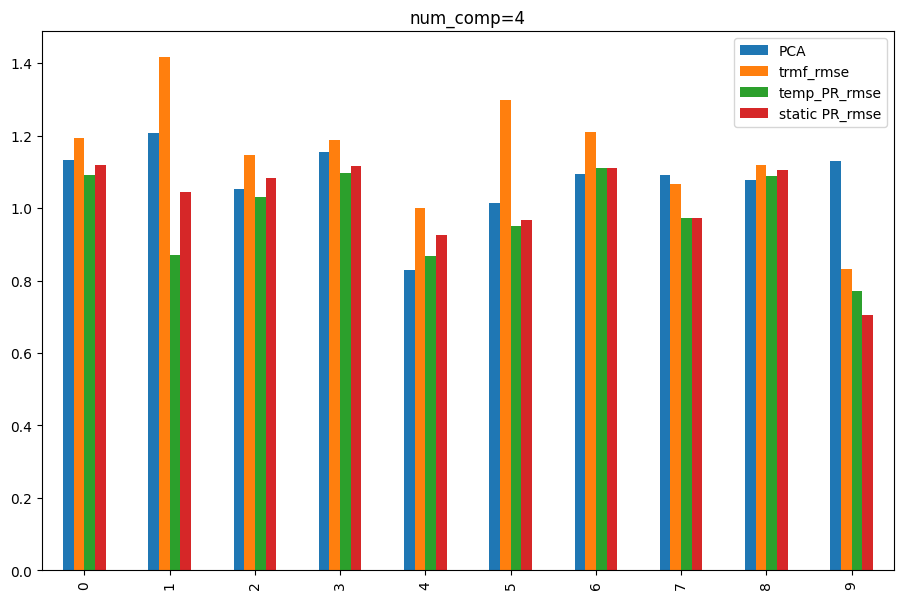

In [16]:
   
dataframe = pd.DataFrame(dict_mse)
plt.rcParams["figure.figsize"] = [11,7]
dataframe.plot(kind="bar",title="num_comp={}".format(num_comp))


In [17]:
dataframe.head(20)

,PCA,trmf_rmse,temp_PR_rmse,static PR_rmse
0,1.133163,1.192699,1.092201,1.120275
1,1.208556,1.416923,0.871067,1.045846
2,1.051871,1.145446,1.029393,1.082868
3,1.156212,1.187866,1.098281,1.116789
4,0.830154,1.000389,0.868071,0.926358
5,1.014493,1.297127,0.949659,0.966368
6,1.093500,1.211083,1.111599,1.111599
7,1.091015,1.067894,0.973155,0.973154
8,1.076903,1.118027,1.087794,1.105651
9,1.130246,0.831954,0.771895,0.705792


In [18]:
dataframe.mean()

PCA               1.078611
trmf_rmse         1.146941
temp_PR_rmse      0.985311
static PR_rmse    1.015470
dtype: float64